In [18]:
using Pkg; Pkg.activate(".")
using Statistics
using PyPlot
using Glob
using DelimitedFiles
using MUST

MUST.@import_dispatch "../../../dispatch2_clean/dispatch2" 
MUST.@import_dispatch "../../../dispatch2_clean/dispatch2" EOS 
MUST.@get_help visual
pl = pyimport("matplotlib.pylab");

  Activating environment at `/cobra/ptmp/peitner/model_grid/MUST.jl/examples/visualize/Project.toml`


read the solar model

In [19]:
solar_model = readdlm("solar_model.txt");

Loading different models. It loads the normal, as well as the optical depth box.

In [20]:
function read_snaps(folder)
    content_of_folder = glob("*/", folder)
    snapshots         = sort(MUST.list_of_snapshots(content_of_folder));
    boxes  = []
    boxesT = []
    for (i_s,snap) in enumerate(snapshots)
        try
            append!(boxes, [MUST.Box("box_sn$(snapshots[i_s])", folder=folder)])
        catch
            #@warn "could not load $(i_s) (spatial)"
        end

        try
            append!(boxesT, [MUST.Box("box_tau_sn$(snapshots[i_s])", folder=folder)])
        catch
            #@warn "could not load $(i_s) (optical depth)"
        end

    end
    boxes, boxesT
end;

In [21]:
folder = MUST.@in_dispatch "data/solar_model_8bins"
m1 = read_snaps(folder);

In [22]:
folder2 = MUST.@in_dispatch "data/solar_model_stagger"
m2 = read_snaps(folder2);

Load the suitable EOS

In [161]:
eos_sqg = MUST.SquareGasEOS(MUST.@in_dispatch("input_data/square_gas_1"));
eos_leg = MUST.@legacyPythonEOS ;

In [162]:
units = MUST.StaggerCGS();

In [163]:
emin = exp(eos_sqg.lnEi_axis[1])
dmin = exp(eos_sqg.lnRho_axis[1])

5.626535f-14

In [164]:
d, e = MUST.meshgrid(eos_sqg.lnRho_axis[1:2:end], eos_sqg.lnEi_axis[1:2:end])
rk   = MUST.lookup(eos_sqg, :rk, d, e; to_log=false);

In [165]:
#rk2 = zeros(eltype(d), size(d2)..., 4)
#for j in size(d2,2)
#    for j in size(d2,1)
#        rk2[i,j] = MUST.lookup(eos_leg, :rk, d[i,j], e[i,j]);
#    end
#end

In [166]:
mask = 1:size(d,1) ;

In [167]:
d0 = convert(Float64, eos_leg.eos.scale0.min)
d1 = convert(Float64, eos_leg.eos.scale0.max)
e0 = convert(Float64, eos_leg.eos.scale1.min)
e1 = convert(Float64, eos_leg.eos.scale1.max)

25.441306598484516

In [168]:
model        = m2[1][end-4]
d_profile    = MUST.plane_statistic(mean, model, :d) ./ units.d
ee_profile   = MUST.plane_statistic(mean, model, :ee) ./ units.ee ;

Plot the diagnostics as plane averages

In [30]:
function plot_diags(boxes, x_axis, ax, colors, stat, diags...; funcs...)
    for i in 1:length(boxes)
        for j in 1:length(diags)
            v  = MUST.plane_statistic(stat, boxes[i], diags[j]) 
            if diags[j] in keys(funcs)
                v = funcs[diags[j]].(v)
            end
            t  = boxes[i][x_axis][1,1,:]
            if x_axis in keys(funcs)
                t = funcs[x_axis].(t)
            end
            ax[j].plot(t, v, label="$(i)", color=colors[i])
        end
    end
end

get_colors(cmap_name, cmap, boxes) = begin
    colors = cmap.(Vector(range(0.1,1.0; length=length(boxes))))
    sm     = plt.cm.ScalarMappable(cmap=cmap_name, norm=plt.Normalize(vmin=0, vmax=length(boxes)))
    (colors, sm)
end;

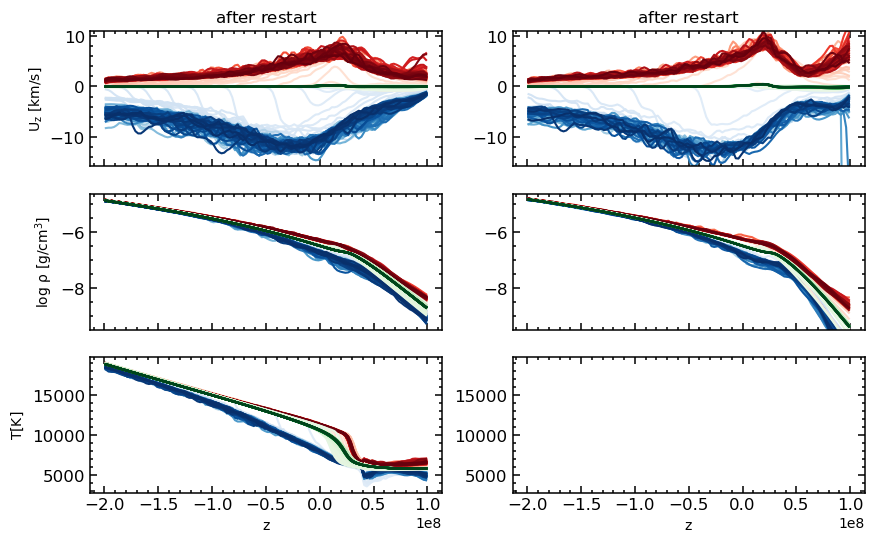

(2853.118371582031, 19845.455114746095)

In [31]:
f, ax = plt.subplots(3, 2, sharex=true, sharey=false, figsize=(10,6))
basic_plot!.(ax)

ax[1,1].set_ylabel(L"\rm U_z\ [km/s]")
ax[2,1].set_ylabel(L"\rm \log\ \rho\ [g/cm^3]")
ax[3,1].set_ylabel(L"\rm T [K]")

#ax[3,1].set_xlabel(L"\rm \log\ \tau_{ross}\ ")
#ax[3,2].set_xlabel(L"\rm \log\ \tau_{ross}\ ")

ax[3,1].set_xlabel(L"\rm z \ ")
ax[3,2].set_xlabel(L"\rm z \ ")


ax[1,1].set_title(L"\rm after\ restart")
ax[1,2].set_title(L"\rm after\ restart")
#ax[1,2].set_title(L"\rm Maximum")


e = length(m1[1]) -2

# First model
c1, sm1 = get_colors("Reds", plt.cm.Reds,   m1[1][2:end-1])
c2, sm2 = get_colors("Blues", plt.cm.Blues, m1[1][2:end-1])
c3, sm3 = get_colors("Greens", plt.cm.Greens, m1[1][2:end-1])

a  = @view ax[:,1]
a2 = @view ax[:,2]
#plt.colorbar(sm1, ax=a)
plot_diags(m1[1][2:end-1], :z, a,  c2, minimum, :uz, :d, :T, d=log10, uz=x->x*1e-5)
plot_diags(m1[1][2:end-1], :z, a,  c1, maximum, :uz, :d, :T, d=log10, uz=x->x*1e-5)
plot_diags(m1[1][2:end-1], :z, a,  c3, mean,    :uz, :d, :T, d=log10, uz=x->x*1e-5)


#plot_diags(m2[2][1:end-2], :τ_ross, a2,  c2, minimum, :uz, :d, :T, d=log10, uz=x->x*1e-5)
#plot_diags(m2[2][1:end-2], :τ_ross, a2,  c1, maximum, :uz, :d, :T, d=log10, uz=x->x*1e-5)
#plot_diags(m2[2][1:end-2], :τ_ross, a2,  c3, mean,    :uz, :d, :T, d=log10, uz=x->x*1e-5)
#plot_diags(m1[2][1:end-2], :τ_ross, a2, c2, mean, :uz, :d, :T, d=log10, uz=x->x*1e-5)


# Second model
c1, sm1 = get_colors("Reds", plt.cm.Reds,   m2[1][2:end-1])
c2, sm2 = get_colors("Blues", plt.cm.Blues, m2[1][2:end-1])
c3, sm3 = get_colors("Greens", plt.cm.Greens, m2[1][2:end-1])

plot_diags(m2[1][2:end-1], :z, a2,  c2, minimum, :uz, :d, :tt, d=log10, uz=x->x*1e-5)
plot_diags(m2[1][2:end-1], :z, a2,  c1, maximum, :uz, :d, :tt, d=log10, uz=x->x*1e-5)
plot_diags(m2[1][2:end-1], :z, a2,  c3, mean,    :uz, :d, :tt, d=log10, uz=x->x*1e-5)

#a = @view ax[:,2]
#c2, sm2 = get_colors("Blues", plt.cm.Blues, m2[2])
#plt.colorbar(sm2, ax=a)
#plot_diags(m2[2], :τ_ross, a, c2, mean, :uz, :d, :T, d=log10, uz=x->x*1e-5)


# solar model
#ax[2,1].plot(solar_model[:,2], solar_model[:,end], color="lime", lw=5)
#ax[3,1].plot(solar_model[:,2], solar_model[:,3], color="lime", lw=5)
#ax[2,2].plot(solar_model[:,2], solar_model[:,end], color="lime", lw=5)
#ax[3,2].plot(solar_model[:,2], solar_model[:,3], color="lime", lw=5)

# revert xlim
ax[1,2].set_ylim(ax[1,1].get_ylim()...)
ax[2,2].set_ylim(ax[2,1].get_ylim()...)
ax[3,2].set_ylim(ax[3,1].get_ylim()...)

#ax[3,1].set_yscale("log")
#ax[3,2].set_yscale("log")
#ax[3,1].set_ylim(4.8e12,6e12)

In [32]:
model        = m2[1][end-4]
d_profile    = MUST.plane_statistic(mean, model, :d) ./ units.d
ee_profile   = MUST.plane_statistic(mean, model, :ee) ./ units.ee 
z1           = model.z[1,1,:];
t1           = MUST.lookup(eos_leg, :T, d_profile, ee_profile);

In [33]:
model        = m1[1][end-4]
d_profile    = MUST.plane_statistic(mean, model, :d) 
ee_profile   = MUST.plane_statistic(mean, model, :ee) 
z2           = model.z[1,1,:];          
t2           = MUST.lookup(eos_sqg, :T, d_profile, ee_profile);


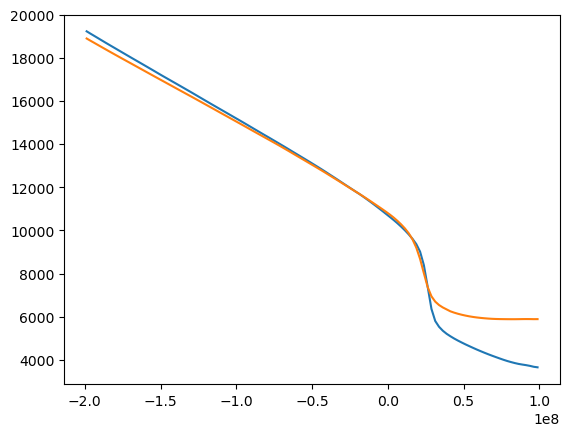

1-element Vector{PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x2ac3667c1820>

In [34]:
plt.plot(z1, t1)
plt.plot(z2, t2)

In [35]:
optical_surface = MUST.height_where(; τ_ross=1.0)
tau_surface     = MUST.reduce_by_column(optical_surface, m1[1][end-2]);

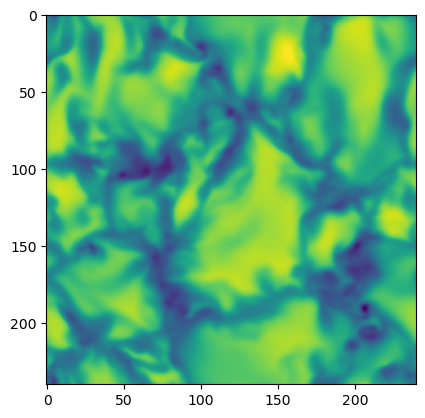

In [36]:
plt.imshow(tau_surface[:z][:,:,1]);

In [37]:
t    = [m1[1][i].parameter.time for i in 1:length(m1[1])]
Teff = [m1[1][i].parameter.teff for i in 1:length(m1[1])];

t2    = [m2[1][i].parameter.time for i in 1:length(m2[1])]
Teff2 = [m2[1][i].parameter.teff for i in 1:length(m2[1])];

In [38]:
dat = readdlm(MUST.@in_dispatch("data/solar_model_stagger/teff.dat"));
t2, teff2 = dat[:,1], dat[:,2];

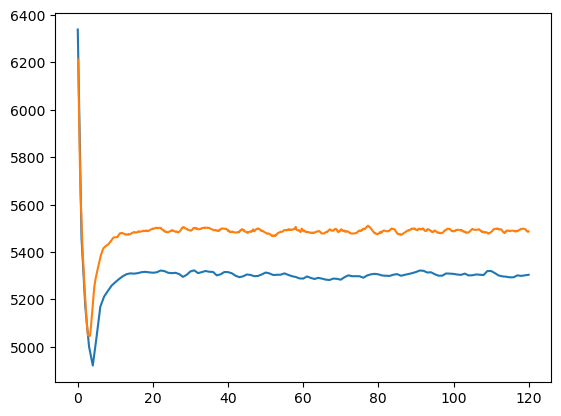

1-element Vector{PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x2ac36680bd90>

In [39]:
plt.plot(t, Teff)
plt.plot(t2, teff2)

In [40]:
#gif_by_value(mean, folder, "logτ = 0",  variable=:T, clabel="T [K]", duration=0.2, τ_ross=0.0, path_ext="t00", cmap="hot");
#gif_by_value(mean, folder2, "logτ = 0",  variable=:T, clabel="T [K]", duration=0.2, τ_ross=0.0, path_ext="t00_rt", cmap="hot");

In [41]:
#optical_surface = MUST.height_where(; z=0.0)
#gif_by_column(optical_surface, m1[1], :d, duration=0.5, cmap="hot", path_ext="d_t00", 
#                vmin=log10(3e-7), vmax=log10(5e-7), d=log10)